In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# import importlib
# importlib.reload(plt)

import icat
import ncfs
import os

from ncfs import distances

# plt.style.use('../src/configs/figures.mplstyle')
# plt.rcParams['figure.constrained_layout.use'] = False

/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/ncfs/distances.py:267: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(phi_s_spec)


In [2]:
mpl.__version__

'3.4.2'

In [3]:
exp_params = {
    "control_kwargs": {
        "dispersion": np.random.choice(range(1, 5), 1500),
        "genes": 1500,
        "p_marker": 0.01,
        "pop_sizes": [
            100,
            100,
            100
        ],
        "populations": 3,
        "samples": 300,
        "scalar": 100
    },
    "perturb_kwargs": {
        "gene_targets": None,
        "new_pop_cells": [
            100,
            100
        ],
        "new_pop_pmarker": 0.01,
        "percent_perturb": 0.05,
        "pop_sizes": [
            100,
            100,
            100
        ],
        "pop_targets": [
            "1"
        ],
        "samples": 300
    }
}

datadir = os.path.join('data', 'simulated', 'schematic-data')
if not os.path.exists(datadir):
    os.makedirs(datadir)
adata_path = os.path.join(datadir, 'adata.h5ad')
if not os.path.exists(adata_path):
    adata = icat.simulate.Experiment(**exp_params).run()[0][0]
    adata.write(adata_path)
else:
    adata = sc.read(adata_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 800 × 1500
    obs: 'Population', 'Treatment', 'batch'
    var: 'Pop.1.Marker', 'Pop.2.Marker', 'Pop.3.Marker', 'Base.Dispersion', 'Base.Mu', 'Pop.1.Mu', 'Pop.1.Dropout', 'Pop.2.Mu', 'Pop.2.Dropout', 'Pop.3.Mu', 'Pop.3.Dropout', 'Perturbation.Shift', 'Pop.Perturbed-1.Marker', 'Pop.Perturbed-added-1.Mu', 'Pop.Perturbed-added-1.Marker', 'Pop.Perturbed-added-2.Mu', 'Pop.Perturbed-added-2.Marker', 'Pop.1.Dropout-Prtb', 'Pop.2.Dropout-Prtb', 'Pop.3.Dropout-Prtb', 'Pop.Perturbed-added-1.Dropout-Prtb', 'Pop.Perturbed-added-2.Dropout-Prtb'

In [5]:
all_markers = np.hstack(list(icat.simulate.population_markers(adata).values()))
markers = []
for pop, genes in icat.simulate.population_markers(adata).items():
    # don't double count
    if pop != 'Perturbed-1':
        gene_means = adata[adata.obs.Population == str(pop)][:, genes].X.mean(axis=0)
        markers.append(genes[np.argsort(-gene_means)][:4])
markers = np.hstack(markers)

In [6]:
adata.obs['Population'].replace({'Perturbed-1': 'stim-1',
                          'Perturbed-added-1': '4',
                          'Perturbed-added-2': '5'},
                                     inplace=True)
adata.obs['Label'] =adata.obs.apply(lambda x: "{}-{}".format(x['Treatment'], x['Population']),
                                               axis=1)
adata.obs['Label'].replace({'Control-1': 'C1',
                     'Perturbed-stim-1': 'P(C1)+',
                     'Control-2': 'C2',
                     'Perturbed-2': 'P(C2)',
                     'Control-3': 'C3',
                     'Perturbed-3': 'P(C3)',
                     'Perturbed-4': 'P4',
                     'Perturbed-5': 'P5'}, inplace=True)
adata.obs['Label'] = pd.Categorical(adata.obs['Label'],
                             ['C1', 'P(C1)+', 'C2', 'P(C2)',
                              'C3', 'P(C3)', 'P4', 'P5'])

In [7]:
# set up color palette for cell labels
paired = sns.color_palette('Paired')
stim_palette = {'C1': paired[1], 'P(C1)+': paired[0], 'P(C1)': paired[0],
                'C2': paired[3], 'P(C2)': paired[2],
                'C3': paired[5], 'P(C3)': paired[4],
                'P4': paired[6], 'P5': paired[8]}
sc.set_figure_params(dpi=200)
label_order = ['C1', 'P(C1)+', 'C2', 'P(C2)', 'C3', 'P(C3)', 'P4', 'P5']

row_palettes = []
for each in ['C1', 'C2', 'C3', 'P4', 'P5']:
    row_palettes += [stim_palette[each]] * 4

In [8]:
len(row_palettes)
len(markers)
sorted(label_order)

['C1', 'C2', 'C3', 'P(C1)+', 'P(C2)', 'P(C3)', 'P4', 'P5']

... storing 'Population' as categorical


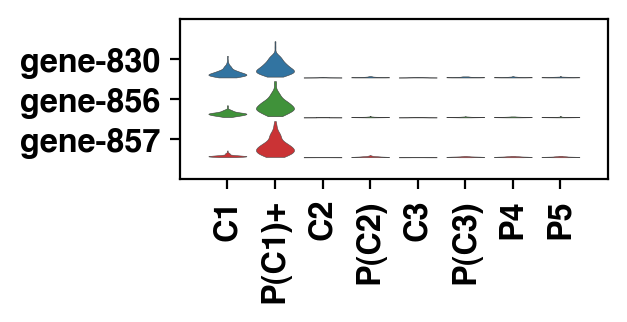

In [9]:
sc.pl.stacked_violin(adata, markers[:3], groupby='Label', swap_axes=True,
                     row_palette=[stim_palette['C1'],
                                  stim_palette['C2'],
                                  stim_palette['C3']])

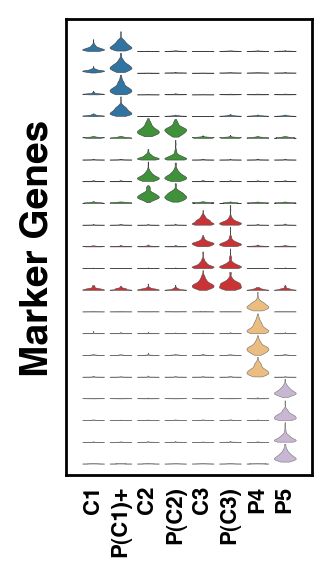

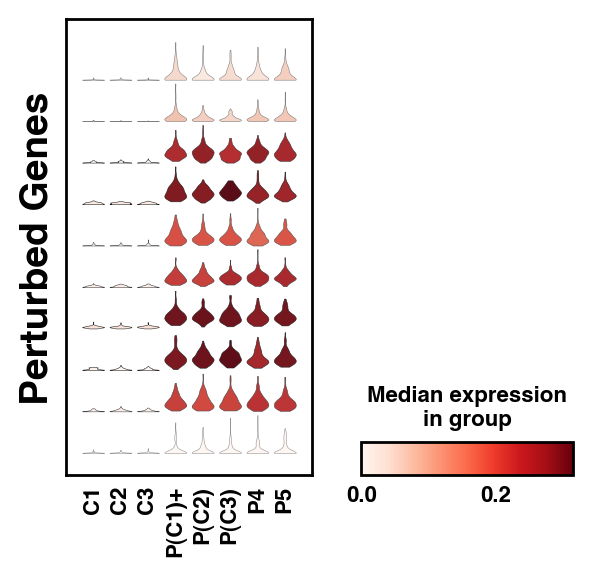

In [10]:
rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "figure.dpi": 200,
      "font.family": "Helvetica"}
# sc.set_figure_params(scanpy=True)
plt.rcParams['figure.dpi'] = 200
with sns.plotting_context("paper", font_scale=1, rc=rc):
    # show marker gene expression
    # fig, ax = plt.subplots(figsize=(7,7))
    axes = sc.pl.stacked_violin(adata, markers, groupby='Label', figsize=(3.25,3),
                                standard_scale=None,
#                                 row_palette=[stim_palette[x] for x in label_order],
                                row_palette=row_palettes, 
                                show=False, cut=0, ax=None, log=False,
                                swap_axes=True)
    axes['mainplot_ax'].set_yticklabels([])
    axes['mainplot_ax'].set_ylabel("Marker Genes", fontsize=14, labelpad=0)
    axes['mainplot_ax'].set_xticklabels(label_order,
                                         weight='normal')
#     axes['mainplot_ax'].annotate('A', (0, 1.05), xycoords='axes fraction', fontsize=36)
    plt.savefig('figures/simulated/marker_genes.svg', bbox_inches='tight')
    plt.show()

    # show perturbed expression profiles
    # fig, ax = plt.subplots(figsize=(7,7))
    shifted = np.random.choice(adata.var.index[adata.var['Perturbation.Shift'] != 1],
                               20)
    psort = np.log2(adata.var['Perturbation.Shift'])\
              .sort_values(ascending=False)\
              .index
    psort = psort[~psort.isin(all_markers)]
    shifted = np.hstack([psort[:10], psort[-10:]])
    shifted = psort[:10]
#     shifted = psort[-10:]

    axes = sc.pl.stacked_violin(adata, shifted, groupby='Label', figsize=(3.25,3),
                                standard_scale='var',
                                categories_order=sorted(label_order),
#                                 row_palette='Reds',
                                cmap='Reds',
                                cut=0,
                                show=False,
                                swap_axes=True,
                                ax=None)
    axes['mainplot_ax'].set_yticklabels([])
    axes['mainplot_ax'].set_ylabel('Perturbed Genes', fontsize=14, labelpad=0)
    # axes['mainplot_ax'].annotate('B', (-0.015, 1.05), xycoords='axes fraction', fontsize=36)
    plt.savefig('figures/simulated/perturbed_genes.svg', bbox_inches='tight',
                dpi=200)
    plt.show()

    # show overall structure in dataset with UMAPs
#     plt.savefig('figures/simulated/population_umap.svg', bbox='tight')
    plt.show()

In [11]:

import icat
model1 = icat.icat('Control', reference='controls')
out1 = model1.cluster(adata.copy(), adata.obs.Treatment)
sc.tl.umap(out1)
model2 = icat.icat('Control', reference='all')
out2 = model2.cluster(adata.copy(), adata.obs.Treatment)
sc.tl.umap(out2)

/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/icat/utils.py:403: UserWarning: Unsupport type <class 'pandas.core.arrays.categorical.Categorical'> for `clusters`
  warnings.warn(f"Unsupport type {type(clusters)} for `clusters`")
/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/ncfs/accelerated.py:147: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/new_icat/lib/python3.8/site-packages/ncfs/accelerated.py", line 64:
@numba.njit(parallel=True, fastmath=True)
def feature_gradient(X, class_matrix, coefs, sample_weights, p_reference,
^

  new_score = partial_fit(X, class_matrix, sample_weights, coefs,
/home/dakota/anaconda3/envs/new_icat/lib/python3.8/site-packages/ncfs/NCFS.py:116: UserWarning: Data m

In [12]:
adata.obs.head()

,Population,Treatment,batch,Label
cell-1-0,1,Control,0,C1
cell-2-0,1,Control,0,C1
cell-3-0,1,Control,0,C1
cell-4-0,1,Control,0,C1
cell-5-0,1,Control,0,C1


In [13]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
out1.obs['Label'] = adata.obs.Label
out2.obs['Label'] = adata.obs.Label
# adata.obs.head()

... storing 'louvain' as categorical
... storing 'louvain' as categorical


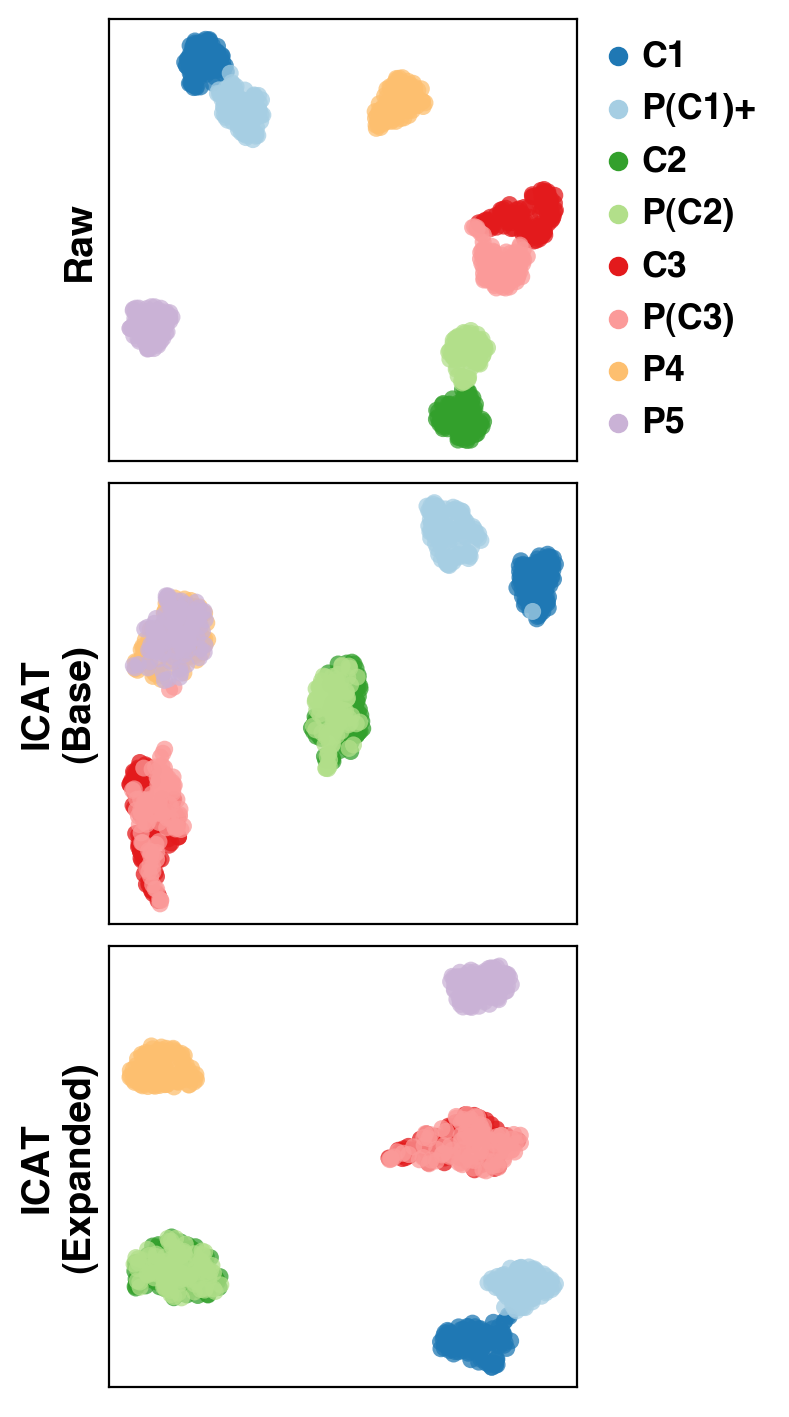

In [14]:
fig, axes = plt.subplots(nrows=3, figsize=(3,9))
ax = sc.pl.umap(adata, color='Label', palette=stim_palette,
           ax=axes[0], show=False, alpha=0.75)
ax.set_xlabel('')
ax.set_ylabel('Raw')
ax.set_title('')
ax = sc.pl.umap(out1, color='Label', palette=stim_palette,
           ax=axes[1], show=False, alpha=0.75)
ax.set_xlabel('')
ax.set_ylabel('ICAT\n(Base)')
ax.set_title('')
ax.legend_.set_visible(False)
ax = sc.pl.umap(out2, color='Label', palette=stim_palette,
               ax=axes[2], show=False, alpha=0.75)
ax.set_xlabel('')
ax.set_ylabel('ICAT\n(Expanded)')
ax.set_title('')
ax.legend_.set_visible(False)
plt.subplots_adjust(hspace=0.05)
plt.savefig('/home/dakota/Pictures/Figures/icat/paper/svgs/extended_comparison.svg')

In [15]:
np.random.seed(69) # lmao
# adata = simulated[0][2].copy()
shifted = np.random.choice(adata.var.index[adata.var['Perturbation.Shift'] != 1],
                           20)
# selected = adata[:, adata.var['Base.Mu-0'] > np.percentile(adata.var['Base.Mu-0'].values, 75)]
psort = np.log2(adata.var['Perturbation.Shift'])\
          .sort_values(ascending=False)\
          .index
psort = psort[~psort.isin(all_markers)]
shifted = np.hstack([psort[:10], psort[-10:]])
# shifted = np.hstack(psort[-20:])
axes = sc.pl.stacked_violin(adata, shifted, groupby='Label', figsize=(4,5),
                            standard_scale='var',
                            row_palette=[stim_palette[x] for x in label_order],
                            cut=0,
                            show=False)
for ax in axes:
    ax.set_yticklabels([])
#     ax.set_ylim(0, 1)
#     ax.set_yticks([0.1, 0.85])
#     ax.set_yticklabels([0, 1], fontsize=18, horizontalalignment='center',
#                        verticalalignment='center')

    ax.tick_params(axis='y', which='major', pad=7)
axes[0].set_xticklabels([])
axes[0].set_xlabel('Perturbed Genes')
axes[-1].annotate('B', (-0.015, 1.05), xycoords='axes fraction', fontsize=36)
plt.savefig('figures/simulated/perturbed_genes.svg', bbox='tight')
plt.show()


AttributeError: 'str' object has no attribute 'set_yticklabels'

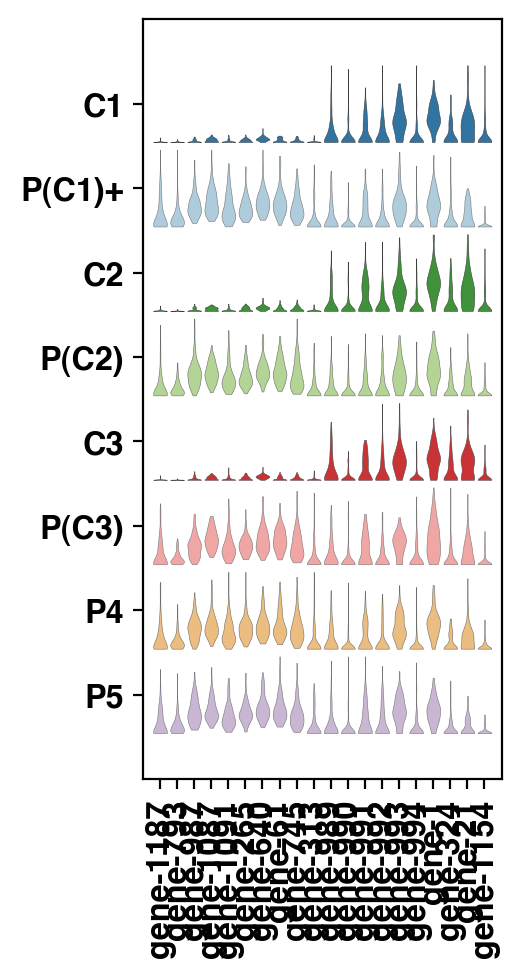

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [17]:
# simulated.flatten()
from itertools import chain
import os

dfs = []
for each in ['gini1', 'gini2', 'gini3']:
    df = pd.read_csv(os.path.join('data', 'simulated', f'{each}.csv'),
                           index_col=0)
    df = df.groupby(['Population', 'Treatment']).size().reset_index()
    df['Experiment'] = each
    df.rename(columns={0: 'Cells'}, inplace=True)
    df['Population'].replace({'Perturbed-1': 'stim-1',
                              'Perturbed-added-1': '4',
                              'Perturbed-added-2': '5'},
                                         inplace=True)
    df['Label'] =df.apply(lambda x: "{}-{}".format(x['Treatment'], x['Population']),
                                                   axis=1)
    df['Label'].replace({'Control-1': 'C1',
                         'Perturbed-stim-1': 'P(C1)',
                         'Control-2': 'C2',
                         'Perturbed-2': 'P(C2)',
                         'Control-3': 'C3',
                         'Perturbed-3': 'P(C3)',
                         'Perturbed-4': 'P4',
                         'Perturbed-5': 'P5'}, inplace=True)
    df['Label'] = pd.Categorical(df['Label'],
                                 ['C1', 'P(C1)', 'C2', 'P(C2)',
                                  'C3', 'P(C3)', 'P4', 'P5'])

    dfs.append(df)

In [54]:
def barplot(df, ax=None, transpose=False):
    df = df.sort_values('Label')
    if ax is None:
        fig, ax = plt.subplots()
    start = 0
    ticklabels = []
    for each in ['Control', 'Perturbed']:
        sub = df[df.Treatment == each]
        ax_bar = ax.bar
        if transpose:
            ax_bar = ax.barh
        ax_bar(range(start, start + sub.Label.nunique()), sub['Cells'],
               color=[stim_palette[x] for x in sub.Label])
        start = start + sub.Label.nunique()
        ticklabels += [x for x in sub.Label]
        if each == 'Control':
            ax_bar([start], 0)
            start += 1
            ticklabels += ['']
    if transpose:
        ax.axhline(y=3, c='black', lw=1)
        ax.set_xlabel('# Cells', fontsize=12)
        ax.set_yticks(range(0, len(ticklabels)))
        ax.set_yticklabels(ticklabels, fontweight=None)
    else:
        ax.axvline(x=3, c='black', lw=1)
        ax.set_ylabel('# Cells', fontsize=12)
        ax.set_xticks(range(0, len(ticklabels)))
        ax.set_xticklabels(ticklabels, rotation=90, fontweight=None)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

In [ ]:
import warnings
fig = plt.figure(figsize=(7,7), constrained_layout=False)
# fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(7, 7),
#                          constrained_layout=False)

# # gs = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
# # 5 rows, 5 columns
gs = fig.add_gridspec(3, 2)
gs01 = gs[:, 0].subgridspec(2, 1)
  
# plot experiment barplots
# gs02 = gs[:4, :].subgridspec(1, 2)
pdf = pd.DataFrame({'% Perturbed': [1, 5, 10, 15, 20, 25]},
                  index=[i for i in range(1, 7)])
pdf['Experiment'] = pdf.index.values
pax = fig.add_subplot(gs01[0, 0])
# pax = axes[0, 0]
pax = sns.barplot(data=pdf, y='% Perturbed', x='Experiment',
            palette=sns.color_palette('Reds', 6), ax=pax)
pax.set_yticks([1, 5, 10, 15, 20, 25])
pax.set_xlabel('')
pax.set_ylabel('Perturbed\nGenes(%)', fontsize=24)
# pax.set_xticklabels(pax.get_xticklabels(), rotation=90)
for spine in ['top', 'right']:
    pax.spines[spine].set_visible(False)
pax.annotate('A', (-.4, 1), xycoords='axes fraction', fontsize=36)

# plot average number of marker genes
sdf = pd.DataFrame({'Avg # Markers': (np.arange(0.007, 0.077, 0.007) * 1500).astype(int)},
                  index=[i for i in range(1, 11)]) 
sdf['Experiment'] = sdf.index.values
sax = fig.add_subplot(gs01[1, 0])
# sax = axes[1, 0]
sax = sns.barplot(data=sdf, y='Avg # Markers', x='Experiment',
                  palette=sns.color_palette('Blues', 10), ax=sax)
sax.set_xlabel(sax.get_xlabel())
sax.set_xlabel('')
sax.set_ylabel("Markers\n(Mean)", fontsize=24)
# sax.set_xticklabels(sax.get_xticklabels(), rotation=90)
for spine in ['top', 'right']:
    sax.spines[spine].set_visible(False)
sax.annotate('B', (-.45, 0.95), xycoords='axes fraction', fontsize=36)

# plot population distributions
count_max = np.max([x['Cells'].max() for x in dfs])
print(count_max)
gs02 = gs[:, 1].subgridspec(3, 1)
# for i, (each, spec) in enumerate(zip(dfs, [(slice(0, 2), slice(0, 4)),
#                                            (slice(0, 2), slice(4, 8)),
#                                            (slice(2, 4), slice(0, 4))],
#                                            (slice(2, 5), slice(4, 8))])):
specs = [(0, 0), (1, 0), (2, 0)]
for i, (each, spec) in enumerate(zip(dfs, specs)):
    ax = fig.add_subplot(gs02[spec])
    ax.set_ylim(0, count_max)
    barplot(each, ax)
    if i in [0, 1]:
        ax.set_xticklabels('')
        if i == 0:
            ax.annotate('Control', (1.75 / 9, 1.05), xycoords='axes fraction',
                    horizontalalignment='center', fontsize=16)
            ax.annotate('Perturbed', (6.5 / 9, 1.05), xycoords='axes fraction',
                    horizontalalignment='center', fontsize=16)
            ax.annotate('C', (-.35, 1), xycoords='axes fraction', fontsize=36)
#     if i != 0:
# #         pass
#         ax.set_ylabel('')
#         ax.set_yticklabels([''])
# axes[-1, 0].set_visible(False)
fig.subplots_adjust(wspace=0.75)#, hspace=0.75)#, top=0.85, bottom=0.05)
plt.savefig('figures/simulated/experiment_schematic.svg', bbox='tight')
plt.show()

In [ ]:
import warnings
rc = {"xtick.major.pad": 0,
      "ytick.major.pad": 0,
      "xtick.major.size": 0,
      "xtick.minor.size": 0,
      "ytick.major.size": 0,
      "ytick.minor.size": 0,
      "lines.linewidth": 2,
      "figure.subplot.left": 0.08,
      "figure.subplot.right": 0.95,
      "figure.subplot.bottom": 0.07,
      "figure.subplot.wspace": 0.25,
      "figure.subplot.hspace": 0.25,
      "legend.labelspacing": 0,
      "legend.handletextpad": 0,
      "legend.columnspacing": 0,
      "font.family": "Helvetica"}
label_order = ['C1', 'P(C1)+', 'C2', 'P(C2)', 'C3', 'P(C3)', 'P4', 'P5']
with sns.plotting_context("paper", font_scale=1.25, rc=rc):

    fig = plt.figure(figsize=(4,4), constrained_layout=False,
                     dpi=200)
    # fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(7, 7),
    #                          constrained_layout=False)

    # # gs = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
    # # 5 rows, 5 columns
    gs = fig.add_gridspec(2, 2)
    gs01 = gs[0, :].subgridspec(1, 2)

    # plot experiment barplots
    # gs02 = gs[:4, :].subgridspec(1, 2)
    pdf = pd.DataFrame({'% Perturbed': [1, 5, 10, 15, 20, 25]},
                      index=[i for i in range(1, 7)])
    pdf['Experiment'] = pdf.index.values
    pax = fig.add_subplot(gs01[0, 0])
    # pax = axes[0, 0]
    pax = sns.barplot(data=pdf, y='% Perturbed', x='Experiment',
                     palette=sns.color_palette('Reds', 5), ax=pax)
    pax.set_yticks([1, 5, 10, 15, 20, 25])
    pax.set_xlabel('')
    pax.set_ylabel('Perturbed\nGenes(%)', fontsize=24)
    # pax.set_xticklabels(pax.get_xticklabels(), rotation=90)
    for spine in ['top', 'right']:
        pax.spines[spine].set_visible(False)
    pax.annotate('D', (-.4, 1), xycoords='axes fraction', fontsize=22)

    # plot average number of marker genes
    sdf = pd.DataFrame({'Avg # Markers': (np.arange(0.007, 0.077, 0.007) * 1500).astype(int)},
                      index=[i for i in range(1, 11)]) 
    sdf['Experiment'] = sdf.index.values
    sax = fig.add_subplot(gs01[0, 1])
    # sax = axes[1, 0]
    sax = sns.barplot(data=sdf, y='Avg # Markers', x='Experiment',
                      palette=sns.color_palette('Blues', 10), ax=sax)
    sax.set_xlabel(sax.get_xlabel())
    sax.set_xlabel('')
    sax.set_ylabel("Markers\n(Mean)", fontsize=12)
    # sax.set_xticklabels(sax.get_xticklabels(), rotation=90)
    for spine in ['top', 'right']:
        sax.spines[spine].set_visible(False)
    sax.annotate('E', (-.45, 0.95), xycoords='axes fraction', fontsize=22)

    # plot population distributions
    count_max = np.max([x['Cells'].max() for x in dfs])
    print(count_max)
    gs02 = gs[1, :].subgridspec(1, 3)
    # for i, (each, spec) in enumerate(zip(dfs, [(slice(0, 2), slice(0, 4)),
    #                                            (slice(0, 2), slice(4, 8)),
    #                                            (slice(2, 4), slice(0, 4))],
    #                                            (slice(2, 5), slice(4, 8))])):
    specs = [(0, 0), (0, 1), (0, 2)]
    for i, (each, spec) in enumerate(zip(dfs, specs)):
        ax = fig.add_subplot(gs02[spec])
        ax.set_xlim(0, count_max)
        barplot(each, ax, transpose=True)
        ax.set_xticks([0, count_max // 2, count_max])
        if i == 2:
    #         ax.annotate('Control', (1.75 / 9, 1.05), xycoords='axes fraction',
    #                 horizontalalignment='center', fontsize=16)
    #         ax.annotate('Perturbed', (6.5 / 9, 1.05), xycoords='axes fraction',
    #                      horizontalalignment='center', fontsize=16)
            ax.annotate('Control', (1.075, 0.425 / 9),
                        xycoords='axes fraction', rotation=270,
                        horizontalalignment='center', fontsize=12)
            ax.annotate('Perturbed', (1.075, 4 / 9),
                        xycoords='axes fraction',
                        rotation=270,
                        horizontalalignment='center', fontsize=12)
        if i == 0:
            ax.annotate('F', (-.4, 1), xycoords='axes fraction', fontsize=22)
    #     if i != 0:
    # #         pass
    #         ax.set_ylabel('')
    #         ax.set_yticklabels([''])
    # axes[-1, 0].set_visible(False)
    fig.subplots_adjust(wspace=1, hspace=0.25)#, hspace=0.75)#, top=0.85, bottom=0.05)
#     plt.savefig('figures/simulated/experiment_schematic.svg', bbox='tight')
    plt.show()

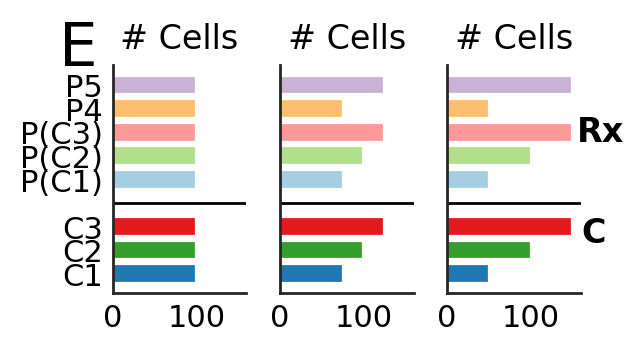

In [68]:
count_max = np.max([x['Cells'].max() for x in dfs])
sns.set_style()
import matplotlib as mpl
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

plt.rcParams['axes.linewidth'] = 3

with sns.plotting_context("paper", font_scale=1.25, rc=rc):
    fig, axes = plt.subplots(ncols=3, figsize=(3, 1.5), dpi=200)
    for i, (each, ax) in enumerate(zip(dfs, axes)):
        ax.set_xlim(0, count_max + 10)
        barplot(each, ax, transpose=True)
        ax.set_xticks([0, 100])
        if i == 2:
            ax.annotate('C', (1.1, 2 / 9),
                        xycoords='axes fraction',
                        fontweight='bold',
#                         rotation=270,
                        horizontalalignment='center', fontsize=12)
            ax.annotate('Rx', (1.15, 6 / 9),
                        xycoords='axes fraction',
                        fontweight='bold',
#                         rotation=270,
                        horizontalalignment='center', fontsize=12)
        if i == 0:
            ax.annotate('E', (-.4, 1), xycoords='axes fraction', fontsize=22)
        else:
            ax.set_yticks([])
        ax.set_title('# Cells')
        ax.set_xlabel('')
        ax.grid(False)
    fig.subplots_adjust(wspace=0.25)
plt.savefig('figures/simulated/pop_proportions.svg', dpi=200,
            bbox_inches='tight')
plt.show()

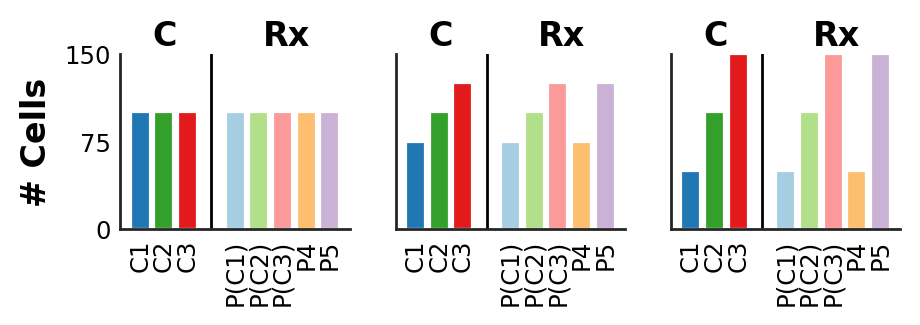

In [95]:
with sns.plotting_context("paper", font_scale=1, rc=rc):
    fig, axes = plt.subplots(ncols=3, figsize=(5, 1.15), dpi=200)
    for i, (each, ax) in enumerate(zip(dfs, axes)):
    #     ax = fig.add_subplot(gs02[spec])
        ax.set_ylim(0, count_max)
        ax.set_yticks([0, count_max // 2, count_max])
        barplot(each, ax)
#         ax.set_xticklabels('')
        ax.annotate('C', (1.75 / 9, 1.05), xycoords='axes fraction',
                    horizontalalignment='center', fontsize=12, fontweight='bold')
        ax.annotate('Rx', (6.5 / 9, 1.05), xycoords='axes fraction',
                    horizontalalignment='center', fontsize=12, fontweight='bold')
        if i != 0:
            ax.set_yticks([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('# Cells', fontweight='bold')

    #             ax.annotate('F', (-.45, 1), xycoords='axes fraction', fontsize=36)
#     plt.show()
plt.savefig('figures/simulated/proportions.svg', dpi=200, bbox_inches='tight')
plt.show()

In [25]:
sdf['% Perturbed'] = 20
# sdf['ExperimentType'] = sdf['Experiment'].apply(lambda x: f"Signal{x}")
pdf['Avg # Markers'] = 15
# pdf['ExperimentType'] = pdf['Experiment'].apply(lambda x: f"Perturbation{x}")
# pd.concat([pdf, sdf])

In [26]:
# pop_labels = ['C1', 'P(C1)+', 'C2', 'P(C2)',
#               'C3', 'P(C3)', 'P4', 'P5']
for df in [pdf, sdf]:
    df.rename(columns={'% Perturbed': 'Perturbed Genes (%)',
                        'Avg # Markers': 'Markers (Mean)'},
               inplace=True)
    df['Cells'] = 800
    df['N Populations'] = 5
    df['Activated Populations'] = 1
    df['Unique Populations'] = 2
#     df['Population+Sizes'] = [";".join([f"{x}, 100" for x in pop_labels])\
#                               for each in df.index]
    df = df[['Experiment', 'Perturbed Genes (%)', 'Markers (Mean)']]

In [27]:
pdf.set_index('Experiment')

,Perturbed Genes (%),Cells,N Populations,Activated Populations,Unique Populations,Markers (Mean)
Experiment,,,,,,
1,5,800,5,1,2,15
2,10,800,5,1,2,15
3,15,800,5,1,2,15
4,20,800,5,1,2,15
5,25,800,5,1,2,15


In [28]:
sdf.set_index('Experiment')

,Markers (Mean),Perturbed Genes (%),Cells,N Populations,Activated Populations,Unique Populations
Experiment,,,,,,
1,10,20,800,5,1,2
2,21,20,800,5,1,2
3,31,20,800,5,1,2
4,42,20,800,5,1,2
5,52,20,800,5,1,2
6,63,20,800,5,1,2
7,73,20,800,5,1,2
8,84,20,800,5,1,2
9,94,20,800,5,1,2


In [34]:
cdf = pd.DataFrame({"Markers (Mean)": [10] * 3,
                      "Perturbed Genes (%)": [20] * 3,
                      "Cells": [800] * 3,
                      "Populations": [5] * 3,
                      "Activated Populations": [0] * 3,
                      "Unique Populations": [3] * 3})
cdf.index.name='Experiment'
cdf

,Markers (Mean),Perturbed Genes (%),Cells,Populations,Activated Populations,Unique Populations
Experiment,,,,,,
0,10,20,800,5,0,3
1,10,20,800,5,0,3
2,10,20,800,5,0,3
